In [1]:
from thesispy.elastix_wrapper.wrapper import run
from thesispy.elastix_wrapper.parameters import Parameters, Collection
from thesispy.experiments.validation import plot_cpoints
from pathlib import Path

2023-01-25 22:20:36,539 - Wrapper - INFO - Running elastix in: ../output/1674681636_learn_1_adaptivestochasticgradientdescent_538473
2023-01-25 22:20:38,371 - Validation - INFO - Calculating validation metrics for LEARN:
2023-01-25 22:20:38,372 - Validation - INFO - TRE: 20.234531816079134
2023-01-25 22:20:39,964 - Validation - INFO - Validation metrics calculated in 1.59s
2023-01-25 22:20:39,965 - Wrapper - INFO - Run ended. It took 3.4254 seconds


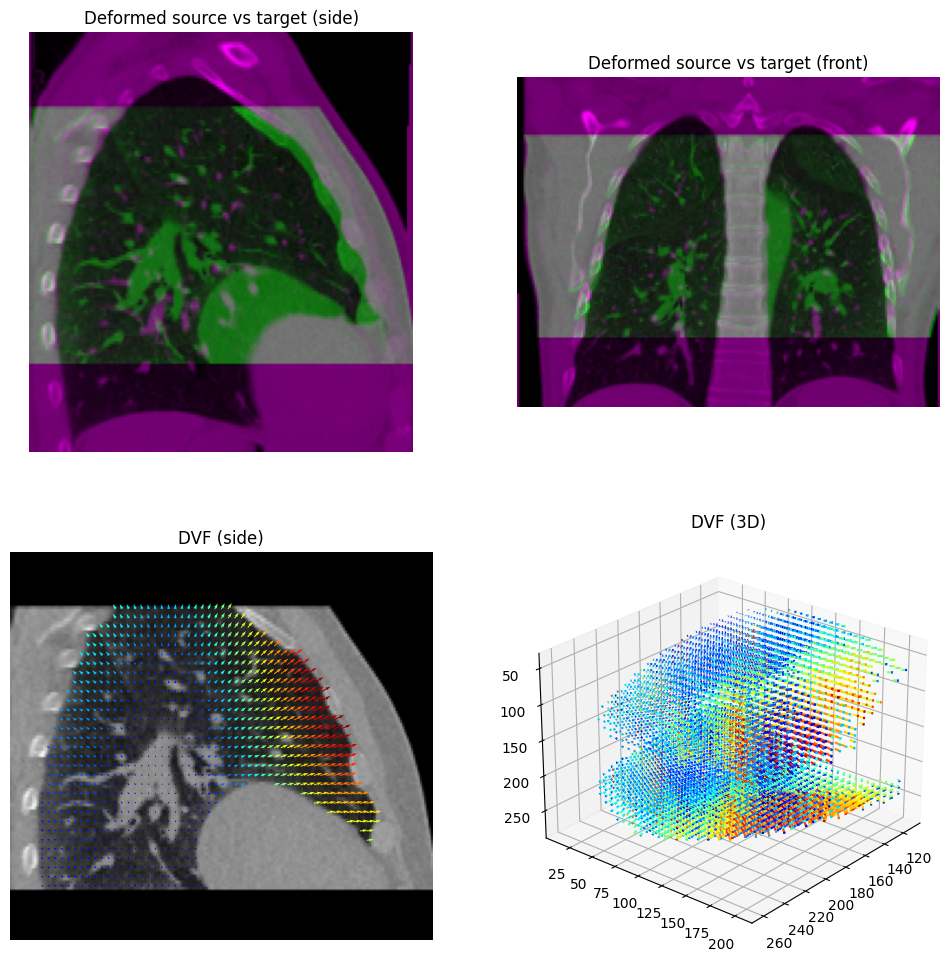

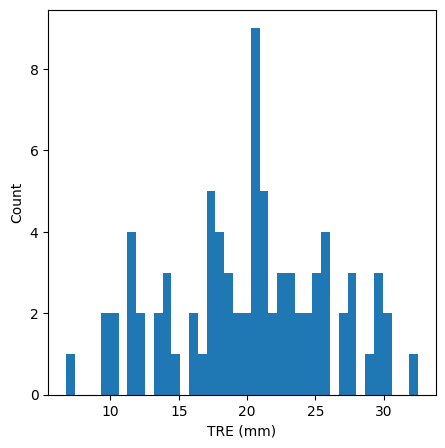

In [2]:
params = (
    Parameters.from_base(mesh_size=5, metric="AdvancedNormalizedCorrelation", seed=1, use_mask=False)
    .asgd()
    .multi_resolution(1, p_sched=[3], downsampling=True)
    .stopping_criteria(3)
    .instance(Collection.LEARN, 1)
)
run_result = run(params, Path("../output/" + str(params)), suppress_stdout=True, visualize=False, validate=True)

In [20]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def plot_color_diff(moving, source, aspect, slice_tuple, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    invert_x = slice_tuple[1] != slice(None, None, None)

    img1 = sitk.GetImageFromArray(moving[slice_tuple])
    img2 = sitk.GetImageFromArray(source[slice_tuple])
    img_min = np.min([img1, img2])
    img_max = np.max([img1, img2])

    img1_255 = sitk.Cast(sitk.IntensityWindowing(img1, windowMinimum=img_min, windowMaximum=img_max, 
                                                outputMinimum=0.0, outputMaximum=255.0), sitk.sitkUInt8)
    img2_255 = sitk.Cast(sitk.IntensityWindowing(img2, windowMinimum=img_min, windowMaximum=img_max, 
                                                outputMinimum=0.0, outputMaximum=255.0), sitk.sitkUInt8)


    img3 = sitk.Cast(sitk.Compose(img1_255, img2_255, img1_255), sitk.sitkVectorUInt8)
    arr = sitk.GetArrayFromImage(img3)

    ax.imshow(arr, aspect=aspect)
    if invert_x:
        ax.invert_xaxis()
    ax.set_ylim(30, 180)
    ax.axis("off")
    return ax.get_figure()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

fixed = run_result.instance.fixed

plot_color_diff(run_result.deformed, fixed, 1.4, (slice(None), slice(None), 50), ax=axes[0])
plot_color_diff(run_result.deformed, fixed, 1.0, (slice(None), 50, slice(None)), ax=axes[1])
fig.tight_layout()

In [ ]:
def plot_dvf_masked(dvf, fixed, mask, spacing, size, direction, slice_tuple, ax=None, zoom_f=1):
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 8))

    image_slice = fixed[slice_tuple]

    inv_mapping = {0: 2, 1: 1, 2: 0}
    indices_xy = list(map(lambda x: inv_mapping[x], np.flip(np.where(np.array(slice_tuple) == slice(None, None, None)))[0]))
    extent = (0, size[indices_xy[0]] * spacing[indices_xy[0]], size[indices_xy[1]] * spacing[indices_xy[1]], 0)

    t=ax.imshow(image_slice,extent=extent,interpolation=None)
    ax.invert_yaxis()
    if slice_tuple[1] != slice(None, None, None):
        ax.invert_xaxis()
    t.set_cmap("gray")

    df_slice = np.copy(dvf[slice_tuple + (slice(None),)])
    mask_slice = mask[slice_tuple]
    df_slice[mask_slice == 0] = np.nan

    direction = np.array(direction).reshape((3,3))
    voxel_to_physical = direction
    physical_to_voxel = np.linalg.inv(voxel_to_physical)

    for i in range(df_slice.shape[0]):
        for j in range(df_slice.shape[1]):
            p = physical_to_voxel @ df_slice[i,j]
            df_slice[i,j] = p

    x = df_slice[:,:,indices_xy[0]]
    y = df_slice[:,:,indices_xy[1]]

    coordsX = np.arange(0, size[indices_xy[0]] * spacing[indices_xy[0]], size[indices_xy[0]] * spacing[indices_xy[0]] / float(dvf.shape[inv_mapping[indices_xy[0]]]) )
    coordsY = np.arange(0, size[indices_xy[1]] * spacing[indices_xy[1]], size[indices_xy[1]] * spacing[indices_xy[1]] / float(dvf.shape[inv_mapping[indices_xy[1]]]) )

    coordsX, coordsY = np.meshgrid(coordsX, coordsY)

    coordsX = coordsX[::zoom_f,::zoom_f]
    coordsY = coordsY[::zoom_f,::zoom_f]
    x = x[::zoom_f,::zoom_f]
    y = y[::zoom_f,::zoom_f]

    M = np.sqrt(x*x+y*y)

    qq=plt.quiver(coordsX, coordsY, x, y, M, cmap=plt.cm.jet, scale_units='xy', angles='xy', scale=1, units='xy', minlength=0)

    ax.axis('off')
    if slice_tuple[1] != slice(None, None, None) or slice_tuple[2] != slice(None, None, None):
        ax.set_ylim(80, 300)
    return ax.get_figure()

In [ ]:
_= plot_dvf_masked(run_result.dvf, run_result.instance.fixed, run_result.instance.mask, run_result.instance.spacing, run_result.instance.size, run_result.instance.direction, (slice(None), slice(None), 50), zoom_f=3)

In [45]:
def plot_dvf_3d(run_result, zoom_f=5, ax=None):
    if ax is None:
        ax = plt.figure(figsize=(10, 10)).add_subplot(projection='3d')
    dvf = np.copy(run_result.dvf)
    mask = run_result.instance.mask
    dvf[mask == 0] = np.nan

    size = run_result.instance.size
    spacing = run_result.instance.spacing
    direction = run_result.instance.direction
    inv_mapping = {0: 2, 1: 1, 2: 0}

    direction = np.array(direction).reshape((3,3))
    voxel_to_physical = direction
    physical_to_voxel = np.linalg.inv(voxel_to_physical)

    dvf = dvf[::zoom_f,::zoom_f,::zoom_f,:]

    for p in np.ndindex(dvf.shape[:3]):
        dvf[p] = physical_to_voxel @ dvf[p]

    coordsX = np.arange(0, size[0] * spacing[0], size[0] * spacing[0] / float(dvf.shape[inv_mapping[0]]))
    coordsY = np.arange(0, size[1] * spacing[1], size[1] * spacing[1] / float(dvf.shape[inv_mapping[1]]))
    coordsZ = np.arange(0, size[2] * spacing[2], size[2] * spacing[2] / float(dvf.shape[inv_mapping[2]]))
    X, Y, Z = np.meshgrid(coordsZ, coordsY, coordsX, indexing='ij')
    x, y, z = dvf[:,:,:,0], dvf[:,:,:,1], dvf[:,:,:,2]

    M = np.sqrt(x*x+y*y+z*z)
    M = M[~np.isnan(M)]    
    
    q = ax.quiver(X, Y, Z, x, y, z, cmap='jet')
    q.set_array(M.flatten())

    ax.invert_zaxis()
    ax.view_init(25, 40)

    return ax.get_figure()

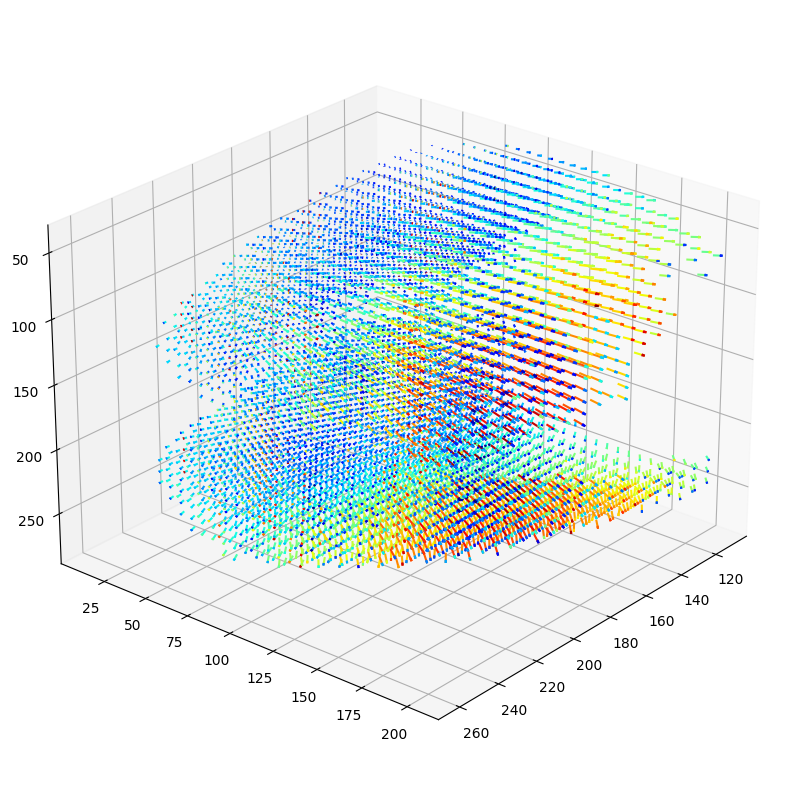

In [46]:
M = plot_dvf_3d(run_result, zoom_f=5)

In [44]:
M.max()

1.0

(array([  9.,   7.,  17.,  29.,  20.,  30.,  28.,  37.,  61.,  52.,  69.,
         79.,  79.,  99., 101., 135., 133., 160., 177., 156., 185., 191.,
        182., 183., 180., 159., 174., 167., 154., 143., 148., 144., 127.,
        126., 115., 113.,  95.,  79.,  85.,  67.,  73.,  66.,  69.,  69.,
         66.,  62.,  64.,  65.,  63.,  61.,  53.,  71.,  47.,  60.,  60.,
         45.,  64.,  57.,  52.,  51.,  52.,  55.,  45.,  54.,  53.,  36.,
         43.,  45.,  49.,  41.,  39.,  39.,  29.,  31.,  34.,  32.,  29.,
         31.,  24.,  24.,  18.,  27.,  32.,  21.,  18.,  15.,  23.,  27.,
         18.,  14.,  13.,  12.,  18.,  11.,   9.,   6.,   7.,   5.,   2.,
          1.]),
 array([0.62657567, 0.69675526, 0.76693485, 0.83711443, 0.90729402,
        0.97747361, 1.0476532 , 1.11783278, 1.18801237, 1.25819196,
        1.32837155, 1.39855113, 1.46873072, 1.53891031, 1.6090899 ,
        1.67926948, 1.74944907, 1.81962866, 1.88980825, 1.95998783,
        2.03016742, 2.10034701, 2.1705266 , 2.

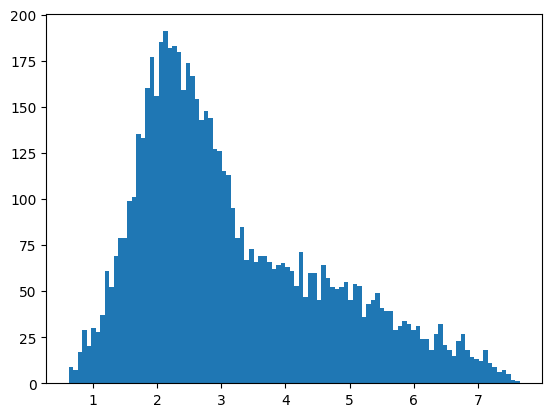

In [35]:
plt.hist(M.flatten(), bins=100)